In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os
print('Tensorflow version:{}'.format(tf.__version__))

Tensorflow version:2.0.0-alpha0


In [2]:
#tf.test.is_gpu_available()

In [2]:
keras=tf.keras
layers=tf.keras.layers

In [3]:
#glob.glob匹配所有的符合条件的文件，并将其以list的形式返回
train_image_path = glob.glob('d:/tf2.0/dataset/dc/train/*.jpg')

In [4]:
len(train_image_path)


1000

In [5]:
train_image_path[-5:]

['d:/tf2.0/dataset/dc/train\\dog.95.jpg',
 'd:/tf2.0/dataset/dc/train\\dog.96.jpg',
 'd:/tf2.0/dataset/dc/train\\dog.97.jpg',
 'd:/tf2.0/dataset/dc/train\\dog.98.jpg',
 'd:/tf2.0/dataset/dc/train\\dog.99.jpg']

In [6]:
train_image_label = [0 for i in range(1000)]
for i in range(500,1000):
    train_image_label[i]=1


In [7]:
train_image_label[:5]

[0, 0, 0, 0, 0]

In [8]:
train_image_label[-5:]

[1, 1, 1, 1, 1]

In [ ]:
#train_image_label=[int(p.split('\\')[1]=='cat') for p in train_image_path]

In [9]:
def load_preprosess_image(path,label):
    image=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,[256,256])
    image=tf.cast(image,tf.float32)
    image=image/255
    return image,label


In [10]:
train_image_ds=tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_image_ds=train_image_ds.map(load_preprosess_image,num_parallel_calls=AUTOTUNE)
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

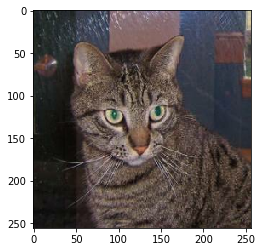

In [11]:
for img,label in train_image_ds.take(2):
    plt.imshow(img)

In [12]:
BATCH_SIZE=32
train_count=len(train_image_path)

In [13]:
train_image_ds=train_image_ds.shuffle(train_count).repeat().batch(BATCH_SIZE)

In [14]:
valid_image_path=glob.glob('d:/tf2.0/dataset/dc/valid/*.jpg')

In [15]:
len(valid_image_path)

1000

In [16]:

#test_image_label=[int(p.split('\\')[1]=='cat') for p in test_image_path]
valid_image_label = [0 for i in range(1000)]
for i in range(500,1000):
     valid_image_label[i]=1

valid_image_ds=tf.data.Dataset.from_tensor_slices((valid_image_path,valid_image_label))
valid_image_ds=valid_image_ds.map(load_preprosess_image,num_parallel_calls=AUTOTUNE)
valid_image_ds=valid_image_ds.repeat().batch(BATCH_SIZE)

In [17]:
valid_count=len(valid_image_path)
valid_count

1000

In [18]:
#kears内置经典网络实现
covn_base=keras.applications.xception.Xception(weights='imagenet',
                                               include_top=False,
                                               input_shape=(256,256,3),
                                               pooling='avg')
covn_base.trainable=False


In [19]:
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [20]:
model=keras.Sequential()
model.add(covn_base)
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
             loss='binary_crossentropy',
             metrics=['acc'])

In [ ]:
initial_epochs=5

In [23]:
history=model.fit(train_image_ds,steps_per_epoch=train_count//BATCH_SIZE,
                 epochs=5,
                 validation_data=valid_image_ds,
                 validation_steps=valid_count//BATCH_SIZE)

Epoch 1/5
31/31 [==============================] - 583s 19s/step - loss: 0.2529 - acc: 0.9103 - val_loss: 0.1227 - val_acc: 0.9567
Epoch 2/5
31/31 [==============================] - 563s 18s/step - loss: 0.1145 - acc: 0.9556 - val_loss: 0.3128 - val_acc: 0.9002
Epoch 3/5
31/31 [==============================] - 563s 18s/step - loss: 0.0777 - acc: 0.9768 - val_loss: 0.0462 - val_acc: 0.9808
Epoch 4/5
31/31 [==============================] - 550s 18s/step - loss: 0.0654 - acc: 0.9768 - val_loss: 0.0747 - val_acc: 0.9738
Epoch 5/5
31/31 [==============================] - 552s 18s/step - loss: 0.0553 - acc: 0.9839 - val_loss: 0.0914 - val_acc: 0.9738


In [ ]:
covn_base.trainable=True

In [ ]:
len(covn_base.layers)

In [ ]:
fine_tune_at=-33

In [ ]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable=False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005/10),
             loss='binary_crossentropy',
             metrics=['acc'])

In [ ]:
fine_tune_epochs=5
total_epochs=initial_epochs+fine_tune_epochs

In [ ]:
history=model.fit(train_image_ds,
                  steps_per_epoch=train_count//BATCH_SIZE,
                  epochs=total_epochs,
                  initial_epoch=initial_epochs,
                  validation_data=valid_image_ds,
                  validation_steps=valid_count//BATCH_SIZE)